In [1]:
import xarray as xr
import pandas as pd
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from math import isnan,pi,exp
from sklearn.calibration import calibration_curve
plt.rcParams['figure.figsize'] = [9, 9]

In [2]:
from ens_util import *

In [3]:
m = np.zeros((7,7))
var = 2
for i in range(7):
    for j in range(7):
        m[i,j] = exp(-((i-3)**2+(j-3)**2)/(2*var))
m = m/m[3,3]

In [4]:
data_files = glob('data_crop*.nc')
res_files = glob('2014*Z_crs_gauss.nc')
#data_files = ['data_crop_04_15.nc']
#res_files = glob('20140415*Z_crs_gauss.nc')
coordx = [258,260]#,262,264]
coordy = [63,65]#,67,69]
thresh = 0.2
data = build_datadf(data_files,coordx,coordy)
(fr15,fr30,fr45,fr60) = build_weighted_fractions(res_files,data.index,data.columns,coordx,coordy,thresh)
fr = [fr15,fr30,fr45,fr60]

data_bin = data.mask(data<thresh,other=1)
data_bin = data_bin.mask(data_bin!=1.0,other=0)

coord = 0
ytrue = data_bin.values[:,coord]
yprob15 = fr15.loc[data_bin.index.values].values[:,coord].astype(np.float)
yprob30 = fr30.loc[data_bin.index.values].values[:,coord].astype(np.float)
yprob45 = fr45.loc[data_bin.index.values].values[:,coord].astype(np.float)
yprob60 = fr60.loc[data_bin.index.values].values[:,coord].astype(np.float)

valid15 = [i for i in range(len(yprob15)) if not np.isnan(yprob15[i])]
valid30 = [i for i in range(len(yprob30)) if not np.isnan(yprob30[i])]
valid45 = [i for i in range(len(yprob45)) if not np.isnan(yprob45[i])]
valid60 = [i for i in range(len(yprob60)) if not np.isnan(yprob60[i])]


#print(ytrue[valid15],yprob15[valid15])
ptrue15,ppred15 = calibration_curve(ytrue[valid15],yprob15[valid15])
ptrue30,ppred30 = calibration_curve(ytrue[valid30],yprob30[valid30])
ptrue45,ppred45 = calibration_curve(ytrue[valid45],yprob45[valid45])
ptrue60,ppred60 = calibration_curve(ytrue[valid60],yprob60[valid60])


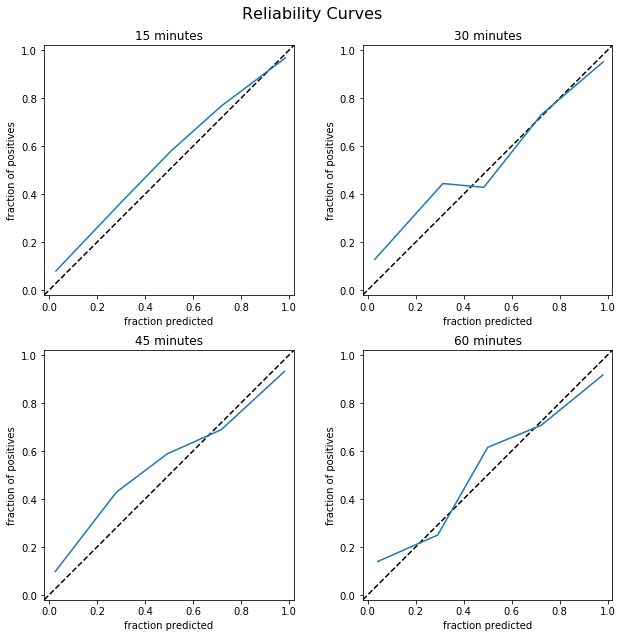

In [5]:
xmin = -0.02
ymin = xmin
xmax = 1.02
ymax = xmax
x = [xmin,xmax]
y = [ymin,ymax]
rows = 2; cols = 2;
fig,axarr = plt.subplots(rows,cols)
for r in range(rows):
    for c in range(cols):
        axarr[r,c].set_aspect('equal','box')
        axarr[r,c].axis([xmin,xmax,ymin,ymax])
        axarr[r,c].plot(x,y,c='k',ls='--')
        axarr[r,c].set_xlabel("fraction predicted")
        axarr[r,c].set_ylabel("fraction of positives")

axarr[0,0].plot(ppred15,ptrue15)
axarr[0,1].plot(ppred30,ptrue30)
axarr[1,0].plot(ppred45,ptrue45)
axarr[1,1].plot(ppred60,ptrue60)

axarr[0,0].set_title("15 minutes")
axarr[0,1].set_title("30 minutes")
axarr[1,0].set_title("45 minutes")
axarr[1,1].set_title("60 minutes")

fig.tight_layout()
fig.suptitle("Reliability Curves",fontsize=16)
fig.subplots_adjust(top=0.92)
plt.show()

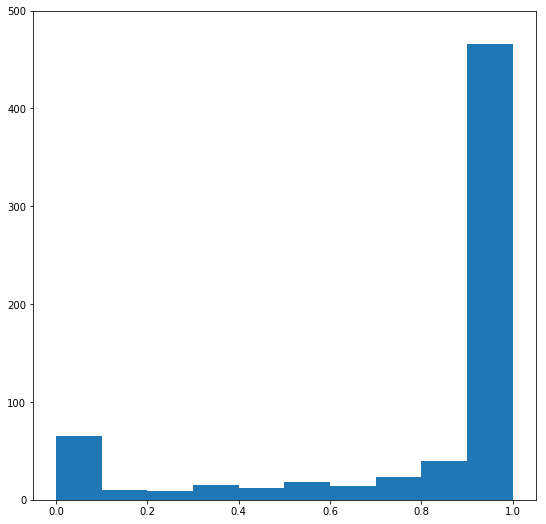

In [6]:
plt.hist(yprob15[valid15])
plt.ylim([0,500])
plt.show()

In [7]:
#old reliability data
oldppred15 = np.array([0.02244898,0.325,0.52692308,0.7625,0.99181287])
oldptrue15 = np.array([0.17346939,0.35,0.76923077,0.82142857,0.96101365])
oldppred30 = np.array([0.03148148,0.32037037,0.53529412,0.76935484,0.98953488])
oldptrue30 = np.array([0.18518519,0.37037037,0.52941176,0.83870968,0.94573643])
oldppred45 = np.array([0.03644068,0.345,0.52857143,0.75568182,0.98861607])
oldptrue45 = np.array([0.15254237,0.5,0.57142857,0.75,0.93303571])
oldppred60 = np.array([0.03555556,0.31578947,0.52142857,0.73625,0.98519814])
oldptrue60 = np.array([0.13333333,0.47368421,0.57142857,0.725,0.91841492])


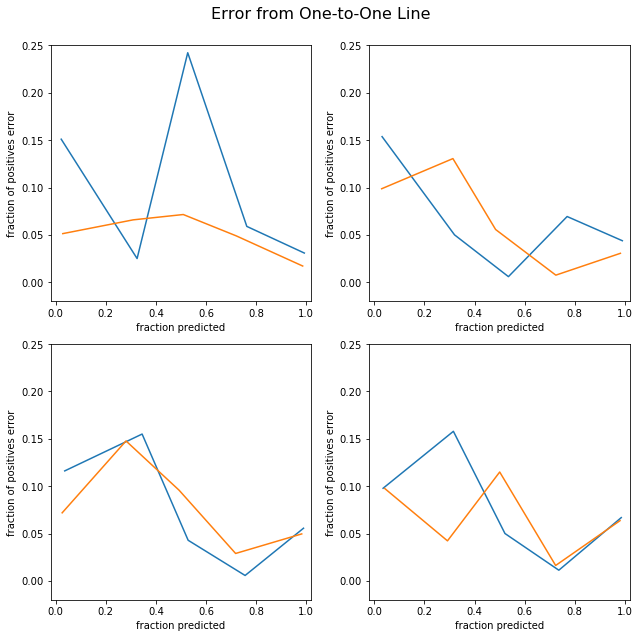

In [8]:
xmin = -0.02
ymin = xmin
xmax = 1.02
ymax = 0.25
x = [xmin,xmax]
y = [ymin,ymax]
rows = 2; cols = 2;
fig,axarr = plt.subplots(rows,cols)
for r in range(rows):
    for c in range(cols):
        #axarr[r,c].set_aspect('equal','box')
        axarr[r,c].axis([xmin,xmax,ymin,ymax])
        axarr[r,c].set_xlabel("fraction predicted")
        axarr[r,c].set_ylabel("fraction of positives error")

axarr[0,0].plot(oldppred15,np.abs(oldptrue15-oldppred15))
axarr[0,1].plot(oldppred30,np.abs(oldptrue30-oldppred30))
axarr[1,0].plot(oldppred45,np.abs(oldptrue45-oldppred45))
axarr[1,1].plot(oldppred60,np.abs(oldptrue60-oldppred60))
        
axarr[0,0].plot(ppred15,np.abs(ptrue15-ppred15))
axarr[0,1].plot(ppred30,np.abs(ptrue30-ppred30))
axarr[1,0].plot(ppred45,np.abs(ptrue45-ppred45))
axarr[1,1].plot(ppred60,np.abs(ptrue60-ppred60))



fig.tight_layout()
fig.suptitle("Error from One-to-One Line",fontsize=16)
fig.subplots_adjust(top=0.92)
plt.show()

add no skill line - Ch. 8 pg 360 abouts in Wilks, enhanced reliability diagram
compute components of brier score, "forecast verification" also in Wilks.
benchmark forecast:
for any pixel, take the fraction of pixels in the satellite image, at each time horizon, that are clear as the probabilistic forecast. Create reliability diagram and look at brier scores.  Go back and look at all brier score stuff to reunderstand.
Original idea with binary plot is not the same as what i want.
Meeting Thursday at 11.